In [13]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '/Users/eman/Documents/' +
                'code_projects/kernellib/kernellib/regression/')

from krr import get_sample_data

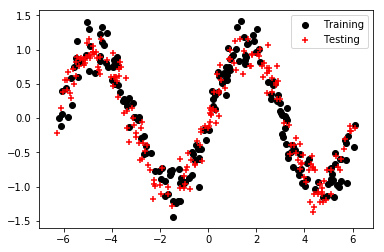

In [14]:
# generate datasets
random_state = 123
num_points = 2000

x_data, y_data = get_sample_data(random_state=random_state,
                                 num_points=num_points)


# split data into training and testing
train_percent = 0.5

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=train_percent,
    random_state=random_state
)

# plot the training data
fig, ax = plt.subplots()

ax.scatter(x_train[::5], y_train[::5], color='k', label='Training')
ax.scatter(x_test[::5], y_test[::5], color='r', marker='+', label='Testing')

ax.legend()
plt.show()

# remove the mean from the training data
y_mean = np.mean(y_train)

y_train -= y_mean
y_test -= y_mean

In [15]:
# parameter heuristics
sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1e-04

gamma = 1 / (2 * sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)
K_test = rbf_kernel(X=x_train, Y=x_test, gamma=mean_gamma)

### Different Solvers

In [19]:
weights = {}

# slow method: solve problem
t0 = time()
weights['solver'] = scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                      y_train)
t1 = time() - t0
print('Time taken for solve: {:.4f} secs'.format(t1))

Time taken for solve: 0.0617 secs


In [20]:
# scikit kernel cholesky solver
t0 = time()
weights['scikit_solver'] = kernel_solve(K_train, y_train, lam)
t1 = time() - t0
print('Time taken for scikit-solver: {:.4f} secs'.format(t1))

Time taken for scikit-solver: 0.0464 secs


In [21]:
# cholesky: decomposition: manually
t0 = time()
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0
print('Time taken for cholesky manually: {:.4f} secs'.format(t1))

Time taken for cholesky manually: 0.0973 secs


In [22]:
# cholesky decomposition: with functions
t0 = time()
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)
t1 = time() - t0
print('Time taken for cholesky with functions: {:.4f} secs'.format(t1))

Time taken for cholesky with functions: 0.0274 secs


#### Are they the same?

In [23]:
print('Scikit Solver: {}'.format(
    np.allclose(weights['scikit_solver'],
                weights['solver'])))

print('Cholesky Solver: {}'.format(
    np.allclose(weights['chol_solver'],
                weights['solver'])))

print('Cholesky Factor: {}'.format(
    np.allclose(weights['chol_factor'],
                weights['solver'])))

Scikit Solver: True
Cholesky Solver: True
Cholesky Factor: True


#### Are they faster?

In [24]:
solver_time = %timeit -o scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), y_train)
scikit_time = %timeit -o kernel_solve(K_train, y_train, lam)

42.8 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.6 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit

# Cholesky Manual Solve
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0

106 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit

# Cholesky Factor Solve
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)

18.1 ms ± 959 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Predictions


In [27]:
y_pred = K_test.T @ weights['solver']

In [28]:
print(weights['solver'].shape)

(1000, 1)


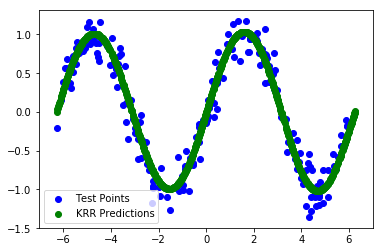

In [29]:
fig, ax = plt.subplots()

ax.scatter(x_test[::5], y_test[::5], color='b', label='Test Points')
ax.scatter(x_test, y_pred, color='g', label='KRR Predictions')


ax.legend()
plt.show()

#### Cross Validation

In [37]:
# split training data into training and validation
validation_percent = 0.2
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=validation_percent,
    random_state=random_state)

num_parameters = 20

# sigma values
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))

mean_gamma = 1 / (2 * mean_sigma ** 2)

min_sigma = np.log(mean_sigma * 0.1)
max_sigma = np.log(mean_sigma * 10)
sigma_values = np.logspace(min_sigma, max_sigma, num_parameters)
gamma_values = 1 / (2 * sigma_values ** 2)

# lambda values
lam_values = np.logspace(-7, 2, num_parameters)

In [38]:


lowest_error = np.inf

t0 = time()
for igamma in gamma_values:
    for ilam in lam_values:
        
        # Construct Kernel Matrices
        K_train = rbf_kernel(X=x_train, gamma=igamma)
        K_valid = rbf_kernel(X=x_train, Y=x_valid, gamma=igamma)
        
        # find the weights
        R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
        weights = cho_solve((R, lower), y_train)
        
        # predict new datapoints
        y_pred = K_valid.T @ weights
        
        # get error measure
        mse = mean_squared_error(y_pred, y_valid)
        
        # grab best value
        if mse < lowest_error:
            lowest_error = mse
            best_gamma = igamma
            best_lam = ilam
        
t1 = time() - t0

Lowest Mean Squared Error: 0.04072760271636643
Best sigma: 1.238, lam: 1e-07
Time Taken for parameters: 1.3127 secs


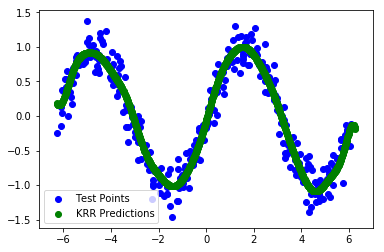

In [39]:
print('Lowest Mean Squared Error: {}'.format(lowest_error))
best_sigma = np.sqrt(1 / (2 * best_gamma))
print('Best sigma: {:.3f}, lam: {}'.format(best_sigma, best_lam))
print('Time Taken for parameters: {:.4f} secs'.format(t1))

# Construct Kernel Matrices
K_train = rbf_kernel(X=x_train, gamma=best_gamma)
K_test = rbf_kernel(X=x_train, Y=x_test, gamma=best_gamma)

# find the weights
weights = scio.linalg.solve(
    K_train + best_lam * np.eye(x_train.shape[0]),y_train)

# predict new datapoints
y_pred = K_test.T @ weights

# plot the results
fig, ax = plt.subplots()

ax.scatter(x_test[::5], y_test[::5], color='b', label='Test Points')
ax.scatter(x_test, y_pred, color='g', label='KRR Predictions')


ax.legend()
plt.show()